Loaded domain text: 1905
Random example: I never thought it would be possible in my lifetime to join with the Patriarch of Moscow and his congregation in a service in that wonderful cathedral in the heart of the Moscow Kremlin.
Splitting to train and validation sets
Train: 1333	Valid: 572
Text Pre-processing...
Num train tokens: 33280	 valid tokens:14232
using pretrained
loading pre-trained model from data_inf\pretrained\fwd_wt103.h5 ...
done
Tuning the last layer for 1 epoch


epoch      trn_loss   val_loss   accuracy                                                                             
    0      4.455579   4.284167   0.227377  


Fine-tuning for 30 epochs


epoch      trn_loss   val_loss   accuracy                                                                             
    0      4.117271   3.9271     0.226061  


epoch      trn_loss   val_loss   accuracy                                                                             
    0      4.159873   3.735189   0.262208  
    1      3.911696   3.599484   0.272617                                                                             
    2      3.643517   3.564383   0.276812                                                                             
    3      3.312082   3.626032   0.272572                                                                             
    4      2.926667   3.785276   0.264036                                                                             
    5      2.552903   3.970139   0.252562                                                                             
    6      2.187722   4.15464    0.249636                                                                             
    7      1.862202   4.366493   0.244805                                                                             
    

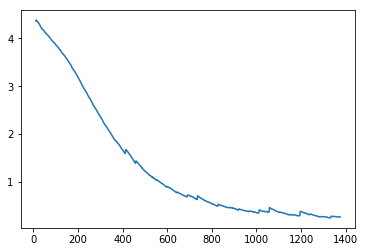

In [28]:
# -*- coding: utf-8 -*-

from fastai_old.text import *

import html

import spacy 

from datetime import datetime

import re

import argparse

import bcolz

from nltk.corpus.reader.plaintext import PlaintextCorpusReader


spacy.load('en_core_web_sm')



# Define help functions

def str2bool(v):

    if isinstance(v, bool):

        return v

    if v.lower() in ('yes', 'true', 't', 'y', '1'):

        return True

    elif v.lower() in ('no', 'false', 'f', 'n', '0'):

        return False

    else:

        raise argparse.ArgumentTypeError('Boolean value expected.')

        

def get_texts(fname, minwords = 100):

    texts = []

    with fname.open('r', encoding='utf-8') as f:

        curr = ['', 0]

        for line in f:

            if line == '\n': # giannis

                continue

            l = len(line.split(' '))

            if curr[1] + l > minwords:

                texts.append(curr[0])

                curr = [line, l]

            else:

                curr[0] += '\n' + line

                curr[1] += l

    if curr[0] != '':

        texts.append(curr[0])

    return np.array(texts)





def get_sentences(fname):

    # Giannis: splitting text into sentences instead of paragraphs. 

    texts = []

    with fname.open('r', encoding='utf-8') as f:

        for line in f:

            if line == '\n': continue

            line = re.sub(r"\[[0-9]+\]", "", line) # replace "[<int>]" by "" (common in dfw_lobster)

            sents = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s', line.strip())

            texts.extend(sents)

    return texts





def fixup(x):

    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(

        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(

        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(

        ' @-@ ','-').replace('\\', ' \\ ').replace('.',' .').replace('?',' ?').replace('!',' !').replace('’'," '")

    re1 = re.compile(r'  +')

    return re1.sub(' ', html.unescape(x))





def preprocess(all_texts):

    col_names = ['text']

    df = pd.DataFrame({'text':all_texts}, columns=col_names)

    texts = df['text'].astype(str)

    texts = list(texts.apply(fixup).values)
    
    s = partition_by_cores(texts)

    tok = Tokenizer().proc_all_mp(s)

    return tok





def get_general_vocab(vocab_path):

    itos = pickle.load((vocab_path).open('rb'))

    stoi = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos)})

    return itos, stoi



def get_domain_vocab(tok, min_freq, max_freq):

    freq = Counter(p for o in tok for p in o)

    itos = [o for o,c in freq.most_common(max_freq) if c>min_freq]

    itos.insert(0, '_pad_')

    itos.insert(0, '_unk_')

    stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

    return itos, stoi



def print_stats(itos, itos2):

    print("itos: {}".format(len(itos)))

    print("itos2: {}".format(len(itos2)))

    print("itos2 - itos: {}".format(len(set(itos2)-set(itos))))

    print("itos - itos2: {}".format(len(set(itos)-set(itos2))))

    print("itos & itos2: {}".format(len(set(itos).union(set(itos2)))))  

    #unseen = set(itos) - set(itos2)

    #print("Domain words not seen previously ({} in total): {}".format(len(unseen), unseen))

    return



def merge_vocab(itos_domain, itos_general, sample_general):

    print("Merging vocabularies")

    if sample_general != -1:

        itos_general = random.sample(itos_general, sample_general)

    itos = list(set(itos_domain).union(itos_general))

    stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

    print("New vocab size = {}".format(len(itos)))

    return itos, stoi





def get_pretrained_weights(itos, stoi2, pre_lm_path, vs, em_sz):

    print('loading pre-trained model from {} ...'.format(pre_lm_path))

    wgts = torch.load(pre_lm_path, map_location=lambda storage, loc: storage)



    enc_wgts = to_np(wgts['0.encoder.weight'])

    row_m = enc_wgts.mean(0)



    new_w = np.zeros((vs, em_sz), dtype=np.float32)

    for i,w in enumerate(itos):                     # for word in imbd vocab

        r = stoi2[w]                                # get the int in the pretrained vocab

        new_w[i] = enc_wgts[r] if r>=0 else row_m   # add weight if in vocab, else add mean weight



    wgts['0.encoder.weight'] = T(new_w)

    wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))

    wgts['1.decoder.weight'] = T(np.copy(new_w))

    print('done')

    return wgts





def build_lm(lm_path, trn_data, val_data, vs, em_sz, bs):

    nh,nl = 1150,3

    bptt=70

    opt_fn = partial(optim.Adam, betas=(0.8, 0.99))



    trn_dl = LanguageModelLoader(np.concatenate(trn_data), bs, bptt)

    val_dl = LanguageModelLoader(np.concatenate(val_data), bs, bptt)

    md = LanguageModelData(lm_path, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)



    drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7



    learner = md.get_model(opt_fn, em_sz, nh, nl, 

        dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

    return learner



def main(num_epochs, valid_size, use_general, sample_general, use_pretrained, batch_size):

    # load domain text
    
    all_texts = []
    '''
    
    from nltk.corpus.reader.plaintext import PlaintextCorpusReader
    
    newcorpus = PlaintextCorpusReader('data_style/data', '.*')
    filenames = newcorpus.fileids()
    
    for f in filenames:
        print(f)
        data_file = NAME + f 
        all_texts += get_sentences(DATA_PATH/data_file)
        
    '''
    
    data_file = NAME + '.txt'
    all_texts = get_sentences(DATA_PATH/data_file)
    
    print("Loaded domain text: {}".format(len(all_texts)))

    print("Random example: {}".format(random.choice(all_texts)))



    #     giannis FIXME: THIS JUST DUPLICATES OUR DATA. USE ONLY FOR DEBUGGING REASONS

    #x = list(all_texts)

    #x.extend(x)

    #x.extend(x)

    #x.extend(x)

    #all_texts = np.array(x)



    print("Splitting to train and validation sets")

    trn_texts,val_texts = sklearn.model_selection.train_test_split(

        all_texts, test_size=valid_size)

    print("Train: {}\tValid: {}".format(len(trn_texts), len(val_texts)))



    print("Text Pre-processing...")

    tok_trn = preprocess(trn_texts)

    tok_val = preprocess(val_texts)

    

    print("Num train tokens: {}\t valid tokens:{}".format(len(np.concatenate(tok_trn)), len(np.concatenate(tok_val))))



    # Loading general & domain vocabularies


    itos_filename = 'itos_' + NAME + ID + '.pkl'

    itos_file = LM_PATH/itos_filename

    general_vocab_path = PRE_PATH/'itos_wt103.pkl'



    itos, stoi = get_domain_vocab(tok_trn, min_freq=1, max_freq=60000)

    itos2, stoi2 = get_general_vocab(general_vocab_path)

    if use_general:

        itos, stoi = merge_vocab(itos, itos2, sample_general=sample_general)

    with open(itos_file, 'wb') as f:

        pickle.dump(itos, f)



    # Converting text to indices

    trn_data = np.array([[stoi[o] for o in p] for p in tok_trn])

    val_data = np.array([[stoi[o] for o in p] for p in tok_val])



    # Loading pre-trained model

    PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

    em_sz = 400

    vs = len(itos)

    learner = build_lm(LM_PATH, trn_data, val_data, vs, em_sz, batch_size)

    if use_pretrained:

        print('using pretrained')

        wgts = get_pretrained_weights(itos, stoi2, PRE_LM_PATH, vs, em_sz)

        learner.model.load_state_dict(wgts)      



    # Fine-tuning 

    learner.metrics = [accuracy]

    learner.freeze_to(-1)

    wd = 1e-7

    lr = 1e-3

    lrs = lr



    print("Tuning the last layer for 1 epoch")

    learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

    learner.save(NAME + ID + '_lm_last_ft')



    print("\n\nFine-tuning for {} epochs".format(num_epochs))

    learner.unfreeze()

    learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

    learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=num_epochs)

    learner.sched.plot_loss()

    lm_name = NAME + ID + '_lm_' + str(num_epochs) + 'epochs'

    print("\nSaving model as {}...".format(lm_name))

    learner.save(lm_name)



#     num_epochs3 = 5

#     learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=num_epochs3)

#     learner.sched.plot_loss()

#     #lm_name = NAME + ID + '_lm_' + str(num_epochs + num_epochs2 + num_epochs3) + 'epochs'

#     lm_name = NAME + ID + '_lm_' + str(num_epochs + num_epochs3) + 'epochs'

#     learner.save(lm_name)



#     print("\nSaving model as {}...".format(SAVE_NAME))

#     learner.save(SAVE_NAME)

    return



if __name__ == '__main__':

    # Define paths & names

    #parser = argparse.ArgumentParser(description='STYLE GENERATION EXPERIMENTS')

    #parser.add_argument('--NAME', nargs='?', type=str, help='Book name', required=False, default='dfw_lobster')

    #parser.add_argument('--num_epochs', nargs='?', type=int, help='Number of epochs', required=False, default=30)

    #parser.add_argument('--valid_size', nargs='?', type=float, help='Validation size (0-1)', required=False, default=0.3)

    #parser.add_argument('--use_general', nargs='?', help='Use general vocabulary?', const=True, required=False, default=False)

    #parser.add_argument('--sample_general', nargs='?', type=int, help='Number of samples to keep from general vocabulary', required=False, default=10000)

    #parser.add_argument('--use_pretrained', nargs='?', help='Use pretrained model?', const=True, required=False, default=True)





    #args = parser.parse_args()

    #args.use_general = str2bool(args.use_general)

    #args.use_pretrained = str2bool(args.use_pretrained)

    #print('Arguments: {}'.format(args))

    
    #DATA_PATH_ALT=Path('data_style/data')
    
    
    
    #data_file_alt = DATA_PATH_ALT + '.txt'
    #all_texts = get_sentences(DATA_PATH/data_file)
    '''
    with open("data_style/result.txt", "w") as outfile:
        for f in read_files:
            with open(DATA_PATH_ALT/f, "r") as infile:
                for line in infile:
                    outfile.write(line)
    '''
    
    
   # with open('data_style/output_file', 'w') as outfile:
    #    for fname in filenames:
     #       with open(DATA_PATH_ALT/fname) as infile:
      #          for line in infile:
       #             outfile.write(line)
                

    NAME = 'all_speeches'

    # giannis: for dfw_lobster we need to manually set a batch size <= number of validation data

    if NAME == 'dfw_lobster': 

        batch_size = 10

    elif NAME == '1952':
        
        batch_size = 10
    
    else:

        batch_size = 10



    num_epochs = 30
    valid_size = 0.3
    use_general = False
    sample_general = 10000
    use_pretrained = True
    
    
    
    DATA_PATH=Path('data_style/')

    DATA_PATH.mkdir(exist_ok=True)


    #LM_PATH = Path('data_inf/custom_lm/{}/'.format(datetime.now().strftime('%b%d_%H-%M-%S')))


    LM_PATH = Path('data_inf/custom_lm/')

    LM_PATH.mkdir(exist_ok=True)


    PRE_PATH=Path('data_inf/pretrained/')

    PRE_PATH.mkdir(exist_ok=True)

    ID = '_test'

    SAVE_NAME = '{}_lm_{}'.format(NAME, num_epochs)

    main(num_epochs, valid_size, use_general, sample_general, use_pretrained, batch_size)